In [1]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
!pip install torch
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:0000:01


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, GlobalAttention

from torchvision import models, transforms

from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

**Graph model with global mean pooling**

In [6]:
class EnhancedGAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, dropout=0.5):
        super(EnhancedGAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=False)
        self.fc1 = Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = Linear(hidden_dim // 2, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

**Graph Model with Weighted Pooling Method**

In [7]:
class EnhancedGATWithWeightedPooling(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, dropout=0.5):
        super(EnhancedGATWithWeightedPooling, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=False)
        self.fc1 = Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = Linear(hidden_dim // 2, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GAT layers
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv3(x, edge_index))

        attention_scores = torch.softmax(x, dim=0)
        weighted_features = attention_scores * x
        graph_representation = weighted_features.mean(dim=0)  # Mean pooling

        x = F.relu(self.fc1(graph_representation))
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)

**1. NO CLIP EMBEDDING, RESNET, Distill Bert Embedding**

**Generating resnet and distillbert embedding**

In [15]:
image_folder = "/kaggle/input/requirement/resources/resources/datasets/harmeme/img"
data_file = "/kaggle/input/with-vqa-data/output_vqa_answers (2).csv"
output_file = "graph_embeddings_512.pt"

data = pd.read_csv(data_file)

resnet = resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()  
resnet.eval().cuda()

bert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
bert_model.eval().cuda()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_mapper = nn.Linear(2048, 512).cuda()  
text_mapper = nn.Linear(768, 512).cuda()  


def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

image_mapper.apply(initialize_weights)
text_mapper.apply(initialize_weights)

def generate_image_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).cuda()
    with torch.no_grad():
        embedding = resnet(image_tensor).squeeze(0)
        embedding = image_mapper(embedding)  
    return embedding.cpu()

def generate_text_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cuda')
    with torch.no_grad():
        embedding = bert_model(**inputs).last_hidden_state.mean(dim=1).squeeze(0)
        embedding = text_mapper(embedding)  
    return embedding.cpu()

embeddings = {
    "train": [],
    "val": [],
    "test": []
}

questions = [
    "What is the race of the person in the image?",
    "What is the gender of the person in the image?",
    "What is the religion of the person in the image?",
    "Which country does the person in the image come from?",
    "Are there disabled people in the image?",
    "What animal is in the image?",
    "Is there a person in the image?",
    "Is there an animal in the image?"
]

tqdm.pandas()
for _, row in tqdm(data.iterrows(), total=len(data)):
    image_filename = row['image']
    image_path = os.path.join(image_folder, image_filename)
    split = row['split']  # train, val, or test
    label = row['label']  # Binary label: 0 or 1

    if not os.path.exists(image_path):
        continue

    image_embedding = generate_image_embedding(image_path)
    text_embedding = generate_text_embedding(row['text'])
    caption_embedding = generate_text_embedding(row['caption'])

    qa_embeddings = []
    for question, answer in zip(questions, row[questions]):
        qa_text = f"{question} {answer}"
        qa_embeddings.append(generate_text_embedding(qa_text))

    embeddings[split].append({
        "image_filename": image_filename,
        "image_embedding": image_embedding,
        "text_embedding": text_embedding,
        "caption_embedding": caption_embedding,
        "qa_embeddings": torch.stack(qa_embeddings),  
        "label": label
    })

torch.save(embeddings, output_file)
print(f"512-Dimension Mapped Embeddings saved to {output_file}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 3544/3544 [04:45<00:00, 12.40it/s]


512-Dimension Mapped Embeddings saved to graph_embeddings_512.pt


**Making Fully Connected Graph**

In [22]:
embedding_file = "graph_embeddings_512.pt"  
embeddings = torch.load(embedding_file)

if not isinstance(embeddings, dict):
    raise TypeError("Expected embeddings to be a dictionary with 'train', 'val', and 'test' splits.")

for split in ["train", "val", "test"]:
    if split not in embeddings:
        raise KeyError(f"Missing split '{split}' in the embeddings dictionary.")
    if not isinstance(embeddings[split], list):
        raise TypeError(f"Expected embeddings['{split}'] to be a list of dictionaries.")
    for i, embedding in enumerate(embeddings[split]):
        if not isinstance(embedding, dict):
            raise TypeError(f"Embedding in {split} at index {i} is not a dictionary.")
        required_keys = ["image_embedding", "text_embedding", "caption_embedding", "qa_embeddings", "label"]
        for key in required_keys:
            if key not in embedding:
                raise KeyError(f"Missing key '{key}' in {split} embedding at index {i}.")

print("Embeddings validated successfully.")

def create_graph(embedding):
    # Combine embeddings for nodes
    image_node = torch.tensor(embedding["image_embedding"]).unsqueeze(0)  # Add batch dim
    text_node = torch.tensor(embedding["text_embedding"]).unsqueeze(0)
    caption_node = torch.tensor(embedding["caption_embedding"]).unsqueeze(0)
    qa_nodes = torch.tensor(embedding["qa_embeddings"])  # QA embeddings as is
    node_features = torch.cat([image_node, text_node, caption_node, qa_nodes], dim=0)

    # Create edges (fully connected graph)
    num_nodes = node_features.size(0)
    edge_indices = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]).t()

    # Create graph
    label = torch.tensor(embedding["label"], dtype=torch.long)
    graph = Data(x=node_features, edge_index=edge_indices, y=label)
    return graph

# Create graphs
train_graphs = [create_graph(e) for e in embeddings["train"]]
val_graphs = [create_graph(e) for e in embeddings["val"]]
test_graphs = [create_graph(e) for e in embeddings["test"]]

# Loaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

print(f"Graphs created: Train {len(train_graphs)}, Val {len(val_graphs)}, Test {len(test_graphs)}")

/tmp/ipykernel_30/2408157923.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embedding_file)


Embeddings validated successfully.


/tmp/ipykernel_30/2408157923.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_node = torch.tensor(embedding["image_embedding"]).unsqueeze(0)  # Add batch dim
/tmp/ipykernel_30/2408157923.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_node = torch.tensor(embedding["text_embedding"]).unsqueeze(0)
/tmp/ipykernel_30/2408157923.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  caption_node = torch.tensor(embedding["caption_embedding"]).unsqueeze(0)
/tmp/ipykernel_30/2408157923.py:40: UserWarning: To copy construct from 

Graphs created: Train 3013, Val 177, Test 354


/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


**Fully connected, Global Mean Pooling (RESNET, BERT EMBEDDING)**

All included(Text, image, captioning, vqa)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_graphs[0].x.size(-1)
hidden_dim = 128
output_dim = 2  # Binary classification
model = EnhancedGAT(input_dim, hidden_dim, output_dim).to(device)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

print("Starting training...")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_labels, val_proba = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            proba = F.softmax(out, dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)
            val_proba.extend(proba)
    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    try:
        val_auroc = roc_auc_score(val_labels, np.array(val_proba)[:, 1])
    except ValueError:
        val_auroc = None

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation AUROC: {val_auroc if val_auroc else 'N/A'}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

print("Training complete!")

# Testing loop
print("Starting testing...")
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
test_preds, test_labels, test_proba = [], [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        preds = out.argmax(dim=1).cpu().numpy()
        proba = F.softmax(out, dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels)
        test_proba.extend(proba)

test_accuracy = accuracy_score(test_labels, test_preds)
try:
    test_auroc = roc_auc_score(test_labels, np.array(test_proba)[:, 1])
except ValueError:
    test_auroc = None

print(f"Test Accuracy: {test_accuracy:.4f}, Test AUROC: {test_auroc if test_auroc else 'N/A'}")

Starting training...
Epoch 1/50, Train Loss: 0.6353, Validation Loss: 0.5330, Validation Accuracy: 0.7006, Validation AUROC: 0.7860373092142453
Epoch 2/50, Train Loss: 0.5419, Validation Loss: 0.5887, Validation Accuracy: 0.6949, Validation AUROC: 0.7641322781232334
Epoch 3/50, Train Loss: 0.4914, Validation Loss: 0.5510, Validation Accuracy: 0.7458, Validation AUROC: 0.8024307518371961
Epoch 4/50, Train Loss: 0.4785, Validation Loss: 0.5540, Validation Accuracy: 0.7288, Validation AUROC: 0.8096382136800452
Epoch 5/50, Train Loss: 0.4753, Validation Loss: 0.7320, Validation Accuracy: 0.6667, Validation AUROC: 0.7942340305257207
Epoch 6/50, Train Loss: 0.4562, Validation Loss: 0.5559, Validation Accuracy: 0.7062, Validation AUROC: 0.788863764838892
Early stopping at epoch 6
Training complete!
Starting testing...
Test Accuracy: 0.7655, Test AUROC: 0.796914446002805


/tmp/ipykernel_30/2505581513.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


without captioning

In [26]:
embedding_file = "graph_embeddings_512.pt"  
embeddings = torch.load(embedding_file)

def create_graph_no_caption(embedding):
    image_node = torch.tensor(embedding["image_embedding"]).unsqueeze(0)
    text_node = torch.tensor(embedding["text_embedding"]).unsqueeze(0)
    qa_nodes = torch.tensor(embedding["qa_embeddings"])
    node_features = torch.cat([image_node, text_node, qa_nodes], dim=0)
    num_nodes = node_features.size(0)
    edge_indices = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]).t()
    label = torch.tensor(embedding["label"], dtype=torch.long)
    return Data(x=node_features, edge_index=edge_indices, y=label)

train_graphs_no_caption, val_graphs_no_caption, test_graphs_no_caption = [], [], []

for i, embedding in enumerate(embeddings["train"] + embeddings["val"] + embeddings["test"]):
    try:
        graph = create_graph_no_caption(embedding)
        if embedding in embeddings["train"]:
            train_graphs_no_caption.append(graph)
        elif embedding in embeddings["val"]:
            val_graphs_no_caption.append(graph)
        elif embedding in embeddings["test"]:
            test_graphs_no_caption.append(graph)
    except Exception as e:
        print(f"Error processing embedding: {e}")

train_loader_no_caption = DataLoader(train_graphs_no_caption, batch_size=32, shuffle=True)
val_loader_no_caption = DataLoader(val_graphs_no_caption, batch_size=32, shuffle=False)
test_loader_no_caption = DataLoader(test_graphs_no_caption, batch_size=32, shuffle=False)

print(f"Graphs created without captioning: Train {len(train_graphs_no_caption)}, Val {len(val_graphs_no_caption)}, Test {len(test_graphs_no_caption)}")

# Model, optimizer, and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim_no_caption = train_graphs_no_caption[0].x.size(-1)
hidden_dim, output_dim = 128, 2
model_no_caption = EnhancedGAT(input_dim_no_caption, hidden_dim, output_dim).to(device)
optimizer = Adam(model_no_caption.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs, patience = 50, 5
best_val_loss_no_caption = float('inf')
early_stop_counter_no_caption = 0

print("Starting training without captioning...")
for epoch in range(epochs):
    model_no_caption.train()
    train_loss = 0
    for batch in train_loader_no_caption:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model_no_caption(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader_no_caption)

    # Validation
    model_no_caption.eval()
    val_loss, val_preds, val_labels, val_probas = 0, [], [], []
    with torch.no_grad():
        for batch in val_loader_no_caption:
            batch = batch.to(device)
            out = model_no_caption(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            probas = torch.exp(out)[:, 1].cpu().numpy() 
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_probas.extend(probas)
            val_labels.extend(labels)
    val_loss /= len(val_loader_no_caption)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_auroc = roc_auc_score(val_labels, val_probas)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation AUROC: {val_auroc:.4f}")

    # Early stopping
    if val_loss < best_val_loss_no_caption:
        best_val_loss_no_caption = val_loss
        early_stop_counter_no_caption = 0
        torch.save(model_no_caption.state_dict(), "best_model_no_caption.pt")
    else:
        early_stop_counter_no_caption += 1
        if early_stop_counter_no_caption >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# Testing
print("Starting testing without captioning...")
model_no_caption.load_state_dict(torch.load("best_model_no_caption.pt"))
model_no_caption.eval()
test_preds, test_labels, test_probas = [], [], []
with torch.no_grad():
    for batch in test_loader_no_caption:
        batch = batch.to(device)
        out = model_no_caption(batch)
        preds = out.argmax(dim=1).cpu().numpy()
        probas = torch.exp(out)[:, 1].cpu().numpy()  
        labels = batch.y.cpu().numpy()
        test_preds.extend(preds)
        test_probas.extend(probas)
        test_labels.extend(labels)

test_accuracy = accuracy_score(test_labels, test_preds)
test_auroc = roc_auc_score(test_labels, test_probas)
print(f"Test Accuracy without captioning: {test_accuracy:.4f}, Test AUROC: {test_auroc:.4f}")


/tmp/ipykernel_30/1471486499.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embedding_file)
/tmp/ipykernel_30/1471486499.py:17: UserWarning: To

Graphs created without captioning: Train 3013, Val 177, Test 354
Starting training without captioning...
Epoch 1/50, Train Loss: 0.6317, Validation Loss: 0.6047, Validation Accuracy: 0.7232, Validation AUROC: 0.7256
Epoch 2/50, Train Loss: 0.5455, Validation Loss: 0.5906, Validation Accuracy: 0.6836, Validation AUROC: 0.7678
Epoch 3/50, Train Loss: 0.4910, Validation Loss: 0.6647, Validation Accuracy: 0.6893, Validation AUROC: 0.7949
Epoch 4/50, Train Loss: 0.4843, Validation Loss: 0.5533, Validation Accuracy: 0.7345, Validation AUROC: 0.7791
Epoch 5/50, Train Loss: 0.4576, Validation Loss: 0.5507, Validation Accuracy: 0.6836, Validation AUROC: 0.7778
Epoch 6/50, Train Loss: 0.4572, Validation Loss: 0.6397, Validation Accuracy: 0.6780, Validation AUROC: 0.7718
Epoch 7/50, Train Loss: 0.4568, Validation Loss: 0.6717, Validation Accuracy: 0.6949, Validation AUROC: 0.7908
Epoch 8/50, Train Loss: 0.4335, Validation Loss: 0.5966, Validation Accuracy: 0.6723, Validation AUROC: 0.7739
Epoch 9

/tmp/ipykernel_30/1471486499.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_caption.load_state_dict(torch.load("best_model_no_caption.pt"))


**ONLY TEXT AND IMAGE WITH RENET AND DISTILL BERT EMBEDDING**

In [27]:
embedding_file = "graph_embeddings_512.pt"  
embeddings = torch.load(embedding_file)

def create_graph_text_image(embedding):
    image_node = torch.tensor(embedding["image_embedding"]).unsqueeze(0)
    text_node = torch.tensor(embedding["text_embedding"]).unsqueeze(0)
    node_features = torch.cat([image_node, text_node], dim=0)
    num_nodes = node_features.size(0)
    edge_indices = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]).t()
    label = torch.tensor(embedding["label"], dtype=torch.long)
    return Data(x=node_features, edge_index=edge_indices, y=label)

train_graphs_text_image, val_graphs_text_image, test_graphs_text_image = [], [], []

for embedding in embeddings["train"]:
    train_graphs_text_image.append(create_graph_text_image(embedding))
for embedding in embeddings["val"]:
    val_graphs_text_image.append(create_graph_text_image(embedding))
for embedding in embeddings["test"]:
    test_graphs_text_image.append(create_graph_text_image(embedding))

train_loader_text_image = DataLoader(train_graphs_text_image, batch_size=32, shuffle=True)
val_loader_text_image = DataLoader(val_graphs_text_image, batch_size=32, shuffle=False)
test_loader_text_image = DataLoader(test_graphs_text_image, batch_size=32, shuffle=False)

print(f"Graphs created: Train {len(train_graphs_text_image)}, Val {len(val_graphs_text_image)}, Test {len(test_graphs_text_image)}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim_text_image = train_graphs_text_image[0].x.size(-1)
hidden_dim, output_dim = 128, 2
model_text_image = EnhancedGAT(input_dim_text_image, hidden_dim, output_dim).to(device)
optimizer = Adam(model_text_image.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

epochs, patience = 50, 5
best_val_loss_text_image = float('inf')
early_stop_counter_text_image = 0

print("Starting training with text and image...")
for epoch in range(epochs):
    model_text_image.train()
    train_loss = 0
    for batch in train_loader_text_image:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model_text_image(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader_text_image)

    model_text_image.eval()
    val_loss, val_preds, val_proba, val_labels = 0, [], [], []
    with torch.no_grad():
        for batch in val_loader_text_image:
            batch = batch.to(device)
            out = model_text_image(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            proba = F.softmax(out, dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_proba.extend(proba[:, 1])  
            val_labels.extend(labels)
    val_loss /= len(val_loader_text_image)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_auroc = roc_auc_score(val_labels, val_proba)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation AUROC: {val_auroc:.4f}")

    
    if val_loss < best_val_loss_text_image:
        best_val_loss_text_image = val_loss
        early_stop_counter_text_image = 0
        torch.save(model_text_image.state_dict(), "best_model_text_image.pt")
    else:
        early_stop_counter_text_image += 1
        if early_stop_counter_text_image >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break


print("Starting testing with text and image...")
model_text_image.load_state_dict(torch.load("best_model_text_image.pt"))
model_text_image.eval()
test_preds, test_proba, test_labels = [], [], []
with torch.no_grad():
    for batch in test_loader_text_image:
        batch = batch.to(device)
        out = model_text_image(batch)
        preds = out.argmax(dim=1).cpu().numpy()
        proba = F.softmax(out, dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        test_preds.extend(preds)
        test_proba.extend(proba[:, 1])  
        test_labels.extend(labels)

test_accuracy = accuracy_score(test_labels, test_preds)
test_auroc = roc_auc_score(test_labels, test_proba)
print(f"Test Accuracy with text and image: {test_accuracy:.4f}, Test AUROC: {test_auroc:.4f}")

/tmp/ipykernel_30/1806820909.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embedding_file)
/tmp/ipykernel_30/1806820909.py:15: UserWarning: To

Graphs created: Train 3013, Val 177, Test 354
Starting training with text and image...
Epoch 1/50, Train Loss: 0.5746, Validation Loss: 0.5707, Validation Accuracy: 0.7119, Validation AUROC: 0.7470
Epoch 2/50, Train Loss: 0.5096, Validation Loss: 0.6212, Validation Accuracy: 0.6667, Validation AUROC: 0.7343
Epoch 3/50, Train Loss: 0.4898, Validation Loss: 0.6763, Validation Accuracy: 0.7232, Validation AUROC: 0.8101
Epoch 4/50, Train Loss: 0.4813, Validation Loss: 0.5374, Validation Accuracy: 0.7006, Validation AUROC: 0.7849
Epoch 5/50, Train Loss: 0.4776, Validation Loss: 0.5957, Validation Accuracy: 0.7119, Validation AUROC: 0.7784
Epoch 6/50, Train Loss: 0.4732, Validation Loss: 0.5380, Validation Accuracy: 0.7514, Validation AUROC: 0.7860
Epoch 7/50, Train Loss: 0.4524, Validation Loss: 0.6280, Validation Accuracy: 0.6780, Validation AUROC: 0.8142
Epoch 8/50, Train Loss: 0.4454, Validation Loss: 0.5404, Validation Accuracy: 0.7119, Validation AUROC: 0.7880
Epoch 9/50, Train Loss: 0

/tmp/ipykernel_30/1806820909.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_text_image.load_state_dict(torch.load("best_model_text_image.pt"))


** 2 CLIP EMBEDDING **

In [4]:
embedding_path = "/kaggle/input/combine-embedding/combined_embeddings.pt"
embeddings = torch.load(embedding_path)

metadata_path = "/kaggle/input/with-vqa-data/output_vqa_answers (2).csv"
df = pd.read_csv(metadata_path)

train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "val"]
test_df = df[df["split"] == "test"]

train_embeddings = [e for e in embeddings if e["image"] in train_df["image"].values]
val_embeddings = [e for e in embeddings if e["image"] in val_df["image"].values]
test_embeddings = [e for e in embeddings if e["image"] in test_df["image"].values]

print(f"Train embeddings: {len(train_embeddings)}")
print(f"Validation embeddings: {len(val_embeddings)}")
print(f"Test embeddings: {len(test_embeddings)}")

/tmp/ipykernel_31/880582190.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embedding_path)


Train embeddings: 3013
Validation embeddings: 177
Test embeddings: 354


In [5]:
torch.save(train_embeddings, "/kaggle/working/train_embeddings.pt")
torch.save(val_embeddings, "/kaggle/working/val_embeddings.pt")
torch.save(test_embeddings, "/kaggle/working/test_embeddings.pt")

print("Embeddings saved successfully!")

Embeddings saved successfully!


In [6]:
train_embeddings = torch.load("/kaggle/working/train_embeddings.pt")
val_embeddings = torch.load("/kaggle/working/val_embeddings.pt")
test_embeddings = torch.load("/kaggle/working/test_embeddings.pt")

print(f"Train: {len(train_embeddings)}, Validation: {len(val_embeddings)}, Test: {len(test_embeddings)}")

/tmp/ipykernel_31/3911106839.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load("/kaggle/working/train_embeddings.pt")


Train: 3013, Validation: 177, Test: 354


/tmp/ipykernel_31/3911106839.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_embeddings = torch.load("/kaggle/working/val_embeddings.pt")
/tmp/ipykernel_31/391110683

MAX_MODEL = IMAGE + TEXT + CAPTION + VQA

In [7]:
def create_graphs_from_embeddings(embeddings):
    graphs = []
    for embed in embeddings:
        
        node_features = torch.stack(
            [embed["image_embedding"], embed["caption_embedding"], embed["meme_text_embedding"]] + list(embed["vqa_embeddings"])
        )  

        
        num_nodes = node_features.size(0)
        edge_indices = [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        
        label = torch.tensor(embed["label"], dtype=torch.long)
        graph = Data(x=node_features, edge_index=edge_index, y=label)
        graphs.append(graph)
    return graphs


train_graphs = create_graphs_from_embeddings(train_embeddings)
val_graphs = create_graphs_from_embeddings(val_embeddings)
test_graphs = create_graphs_from_embeddings(test_embeddings)

**Fully Connected + Mean pooling**

In [8]:
class EnhancedGAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, dropout=0.5):
        super(EnhancedGAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=False)
        self.fc1 = Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = Linear(hidden_dim // 2, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if x.dim() == 3:
            x = x.squeeze(1)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)  # Graph-level pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

**Fully connected + Global attention pooling**

In [9]:
class EnhancedGATWithAttentionPooling(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, dropout=0.5):
        super(EnhancedGATWithAttentionPooling, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=False)
        
        # Attention mechanism for global pooling
        self.attention_gate = Linear(hidden_dim, 1)  # Gate for attention scores
        self.global_attention = GlobalAttention(self.attention_gate)
        
        # Fully connected layers
        self.fc1 = Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = Linear(hidden_dim // 2, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        if x.dim() == 3:
            x = x.squeeze(1)  # Flatten if 3D tensor
        
        # GAT layers
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        
        # Global Attention Pooling
        x = self.global_attention(x, batch)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
batch_size = 32
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

In [12]:
def create_graphs_from_embeddings(embeddings):
    graphs = []
    for embed in embeddings:
        node_features = torch.stack(
            [embed["image_embedding"], embed["meme_text_embedding"]] + list(embed["vqa_embeddings"])
        )  

        # Edge indices (fully connected)
        num_nodes = node_features.size(0)
        edge_indices = [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        # Labels
        label = torch.tensor(embed["label"], dtype=torch.long)

        # Create graph
        graph = Data(x=node_features, edge_index=edge_index, y=label)
        graphs.append(graph)
    return graphs

train_graphs = create_graphs_from_embeddings(train_embeddings)
val_graphs = create_graphs_from_embeddings(val_embeddings)
test_graphs = create_graphs_from_embeddings(test_embeddings)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_graphs[0].x.size(-1)  # Feature size
hidden_dim = 128
output_dim = 2  # Binary classification

model = EnhancedGATWithAttentionPooling(input_dim, hidden_dim, output_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

print("Model initialized and ready for training!")

Model initialized and ready for training!


/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


In [16]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  
        loss = criterion(out, data.y)  
        loss.backward()  
        optimizer.step() 

        total_loss += loss.item()

        preds = out.argmax(dim=1).detach().cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)  
            loss = criterion(out, data.y) 

            total_loss += loss.item()
            
            probs = F.softmax(out, dim=1)[:, 1].detach().cpu().numpy()  
            labels = data.y.cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels)

    preds = np.array(all_probs) > 0.5  
    acc = accuracy_score(all_labels, preds)
    try:
        auroc = roc_auc_score(all_labels, all_probs)
    except ValueError: 
        auroc = 0.0
    return total_loss / len(loader), acc, auroc

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_auroc = validate(model, val_loader, criterion, device)

        print(f"Epoch {epoch}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUROC: {val_auroc:.4f}")

train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=50)

Epoch 1/50
Train Loss: 0.0406, Train Acc: 0.9871
Val Loss: 1.3378, Val Acc: 0.7853, Val AUROC: 0.8555
Epoch 2/50
Train Loss: 0.0321, Train Acc: 0.9867
Val Loss: 1.7356, Val Acc: 0.7514, Val AUROC: 0.8475
Epoch 3/50
Train Loss: 0.0415, Train Acc: 0.9841
Val Loss: 2.1453, Val Acc: 0.7345, Val AUROC: 0.8426
Epoch 4/50
Train Loss: 0.0867, Train Acc: 0.9668
Val Loss: 1.1862, Val Acc: 0.7684, Val AUROC: 0.8437
Epoch 5/50
Train Loss: 0.0482, Train Acc: 0.9801
Val Loss: 1.1746, Val Acc: 0.7740, Val AUROC: 0.8549
Epoch 6/50
Train Loss: 0.0482, Train Acc: 0.9804
Val Loss: 1.1106, Val Acc: 0.7627, Val AUROC: 0.8341
Epoch 7/50
Train Loss: 0.0314, Train Acc: 0.9881
Val Loss: 1.5940, Val Acc: 0.7514, Val AUROC: 0.8452
Epoch 8/50
Train Loss: 0.0278, Train Acc: 0.9887
Val Loss: 1.3122, Val Acc: 0.7627, Val AUROC: 0.8462
Epoch 9/50
Train Loss: 0.0496, Train Acc: 0.9781
Val Loss: 1.2409, Val Acc: 0.7684, Val AUROC: 0.8455
Epoch 10/50
Train Loss: 0.0385, Train Acc: 0.9831
Val Loss: 1.5685, Val Acc: 0.711

In [17]:
def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)  
            loss = criterion(out, data.y) 

            total_loss += loss.item()

            probs = F.softmax(out, dim=1)[:, 1].detach().cpu().numpy()  
            labels = data.y.cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels)

    preds = np.array(all_probs) > 0.5  
    acc = accuracy_score(all_labels, preds)
    try:
        auroc = roc_auc_score(all_labels, all_probs)
    except ValueError: 
        auroc = 0.0
    return total_loss / len(loader), acc, auroc

In [18]:
test_loss, test_acc, test_auroc = test(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUROC: {test_auroc:.4f}")

Test Loss: 1.2406
Test Accuracy: 0.7966
Test AUROC: 0.8805


**Global Mean Pooling + Fully Connected**

Total trainable parameters in the model: 799,042
Starting training...
Epoch 1/50, Train Loss: 0.4949, Validation Loss: 0.5308, Validation Accuracy: 0.7514
Epoch 2/50, Train Loss: 0.4170, Validation Loss: 0.5914, Validation Accuracy: 0.7288
Epoch 3/50, Train Loss: 0.3771, Validation Loss: 0.5439, Validation Accuracy: 0.7514
Epoch 4/50, Train Loss: 0.3361, Validation Loss: 0.5270, Validation Accuracy: 0.7571
Epoch 5/50, Train Loss: 0.3085, Validation Loss: 0.6530, Validation Accuracy: 0.7119
Epoch 6/50, Train Loss: 0.2753, Validation Loss: 0.6622, Validation Accuracy: 0.7571
Epoch 7/50, Train Loss: 0.2459, Validation Loss: 0.9518, Validation Accuracy: 0.6949
Epoch 8/50, Train Loss: 0.2221, Validation Loss: 0.6719, Validation Accuracy: 0.8023
Epoch 9/50, Train Loss: 0.1950, Validation Loss: 0.9537, Validation Accuracy: 0.7345
Early stopping at epoch 9
Training complete.
Starting testing with AUROC calculation...
Test Accuracy: 0.8136
Test AUROC: 0.8895
Confusion Matrix:
[[178  52]
 [ 14 1

/tmp/ipykernel_30/3896755462.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


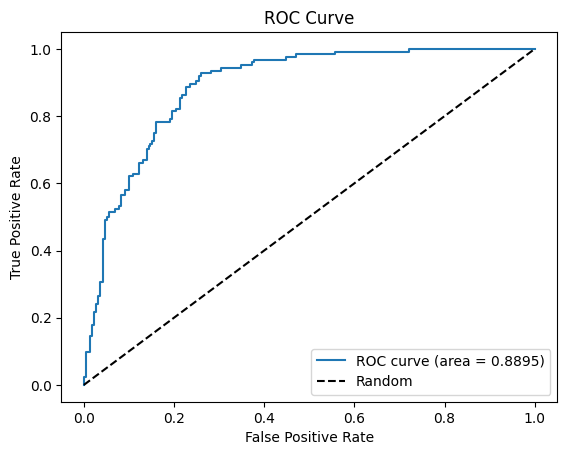

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = graphs[0].x.size(-1)
hidden_dim = 128
output_dim = 2  # Binary classification
model = EnhancedGAT(input_dim, hidden_dim, output_dim).to(device)
print(f"Total trainable parameters in the model: {count_parameters(model):,}")

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

epochs = 50
print("Starting training...")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            if batch.x.dim() == 3:
                batch.x = batch.x.squeeze(1)
            out = model(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)
    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    scheduler.step()

print("Training complete.")

def calculate_auroc(y_true, y_pred_proba):
    auroc = roc_auc_score(y_true, y_pred_proba[:, 1])
    return auroc

def plot_roc_curve(y_true, y_pred_proba):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_score(y_true, y_pred_proba[:, 1]):.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

print("Starting testing with AUROC calculation...")
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
test_preds, test_labels, test_proba = [], [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        out = model(batch)
        preds = out.argmax(dim=1).cpu().numpy()
        proba = torch.exp(out).cpu().numpy()  # Get probabilities using softmax
        labels = batch.y.cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels)
        test_proba.extend(proba)

test_accuracy = accuracy_score(test_labels, test_preds)
conf_matrix = confusion_matrix(test_labels, test_preds)
test_proba = np.array(test_proba)
test_auroc = calculate_auroc(test_labels, test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUROC: {test_auroc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot the ROC curve
plot_roc_curve(test_labels, test_proba)


Without VQA

Starting training without VQA...
Epoch 1/50, Train Loss: 0.4890, Validation Loss: 0.5401, Validation Accuracy: 0.7232
Epoch 2/50, Train Loss: 0.4149, Validation Loss: 0.5042, Validation Accuracy: 0.7571
Epoch 3/50, Train Loss: 0.3942, Validation Loss: 0.6003, Validation Accuracy: 0.7514
Epoch 4/50, Train Loss: 0.3452, Validation Loss: 0.6104, Validation Accuracy: 0.7571
Epoch 5/50, Train Loss: 0.3171, Validation Loss: 0.7317, Validation Accuracy: 0.7345
Epoch 6/50, Train Loss: 0.2687, Validation Loss: 0.8287, Validation Accuracy: 0.6949
Epoch 7/50, Train Loss: 0.2425, Validation Loss: 1.0068, Validation Accuracy: 0.7232
Early stopping at epoch 7
Training without VQA complete.
Starting testing without VQA...
Test Accuracy without VQA: 0.8362
Test AUROC without VQA: 0.9096
Confusion Matrix without VQA:
[[192  38]
 [ 20 104]]


/tmp/ipykernel_30/1716547324.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_vqa.load_state_dict(torch.load("best_model_no_vqa.pt"))


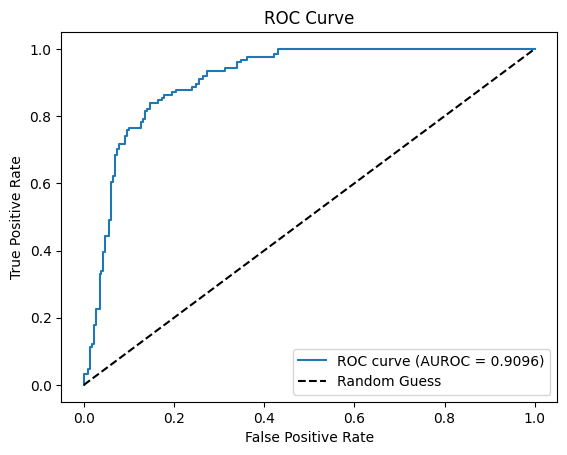

In [34]:
def create_graphs_without_vqa(embeddings):
    graphs = []
    for embed in embeddings:
        
        node_features = torch.stack(
            [embed["image_embedding"], embed["caption_embedding"], embed["meme_text_embedding"]]
        )  
        num_nodes = node_features.size(0)
        edge_indices = [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        label = torch.tensor(embed["label"], dtype=torch.long)
        graph = Data(x=node_features, edge_index=edge_index, y=label)
        graphs.append(graph)
    return graphs

train_graphs_no_vqa = create_graphs_without_vqa(train_embeddings)
val_graphs_no_vqa = create_graphs_without_vqa(val_embeddings)
test_graphs_no_vqa = create_graphs_without_vqa(test_embeddings)

batch_size = 32
train_loader_no_vqa = DataLoader(train_graphs_no_vqa, batch_size=batch_size, shuffle=True)
val_loader_no_vqa = DataLoader(val_graphs_no_vqa, batch_size=batch_size, shuffle=False)
test_loader_no_vqa = DataLoader(test_graphs_no_vqa, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim_no_vqa = train_graphs_no_vqa[0].x.size(-1)
hidden_dim = 128
output_dim = 2  
model_no_vqa = EnhancedGAT(input_dim_no_vqa, hidden_dim, output_dim).to(device)
optimizer = Adam(model_no_vqa.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_loss_no_vqa = float('inf')
early_stop_counter_no_vqa = 0
patience = 5

epochs = 50
print("Starting training without VQA...")
for epoch in range(epochs):
    
    model_no_vqa.train()
    train_loss_no_vqa = 0
    for batch in train_loader_no_vqa:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        optimizer.zero_grad()
        out = model_no_vqa(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss_no_vqa += loss.item()
    train_loss_no_vqa /= len(train_loader_no_vqa)

    model_no_vqa.eval()
    val_loss_no_vqa = 0
    val_preds_no_vqa, val_labels_no_vqa = [], []
    with torch.no_grad():
        for batch in val_loader_no_vqa:
            batch = batch.to(device)
            if batch.x.dim() == 3:
                batch.x = batch.x.squeeze(1)
            out = model_no_vqa(batch)
            loss = criterion(out, batch.y)
            val_loss_no_vqa += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds_no_vqa.extend(preds)
            val_labels_no_vqa.extend(labels)
    val_loss_no_vqa /= len(val_loader_no_vqa)
    val_accuracy_no_vqa = accuracy_score(val_labels_no_vqa, val_preds_no_vqa)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_no_vqa:.4f}, Validation Loss: {val_loss_no_vqa:.4f}, Validation Accuracy: {val_accuracy_no_vqa:.4f}")

    if val_loss_no_vqa < best_val_loss_no_vqa:
        best_val_loss_no_vqa = val_loss_no_vqa
        early_stop_counter_no_vqa = 0
        torch.save(model_no_vqa.state_dict(), "best_model_no_vqa.pt")
    else:
        early_stop_counter_no_vqa += 1
        if early_stop_counter_no_vqa >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    scheduler.step()

print("Training without VQA complete.")

print("Starting testing without VQA...")
model_no_vqa.load_state_dict(torch.load("best_model_no_vqa.pt"))
model_no_vqa.eval()
test_preds_no_vqa, test_labels_no_vqa, test_proba_no_vqa = [], [], []
with torch.no_grad():
    for batch in test_loader_no_vqa:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        out = model_no_vqa(batch)
        preds = out.argmax(dim=1).cpu().numpy() 
        proba = torch.exp(out).cpu().numpy()  
        labels = batch.y.cpu().numpy()

        test_preds_no_vqa.extend(preds)
        test_labels_no_vqa.extend(labels)
        test_proba_no_vqa.extend(proba)

test_proba_no_vqa = np.array(test_proba_no_vqa)

test_accuracy_no_vqa = accuracy_score(test_labels_no_vqa, test_preds_no_vqa)

test_auroc_no_vqa = roc_auc_score(test_labels_no_vqa, test_proba_no_vqa[:, 1])

conf_matrix_no_vqa = confusion_matrix(test_labels_no_vqa, test_preds_no_vqa)
print(f"Test Accuracy without VQA: {test_accuracy_no_vqa:.4f}")
print(f"Test AUROC without VQA: {test_auroc_no_vqa:.4f}")
print("Confusion Matrix without VQA:")
print(conf_matrix_no_vqa)

plot_roc_curve(test_labels_no_vqa, test_proba_no_vqa[:, 1])

Without Captioning(BEST MODEL)

Starting training without Captioning...
Epoch 1/50, Train Loss: 0.4971, Validation Loss: 0.4436, Validation Accuracy: 0.7910
Epoch 2/50, Train Loss: 0.4226, Validation Loss: 0.5438, Validation Accuracy: 0.7232
Epoch 3/50, Train Loss: 0.3824, Validation Loss: 0.4815, Validation Accuracy: 0.7966
Epoch 4/50, Train Loss: 0.3419, Validation Loss: 0.5015, Validation Accuracy: 0.7627
Epoch 5/50, Train Loss: 0.3018, Validation Loss: 0.5774, Validation Accuracy: 0.7345
Epoch 6/50, Train Loss: 0.2774, Validation Loss: 0.6957, Validation Accuracy: 0.7684
Early stopping at epoch 6
Training without Captioning complete.
Starting testing without Captioning...
Test Accuracy without Captioning: 0.8475
Test AUROC without Captioning: 0.9094
Confusion Matrix without Captioning:
[[196  34]
 [ 20 104]]


/tmp/ipykernel_30/1519695365.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_caption.load_state_dict(torch.load("best_model_no_caption.pt"))


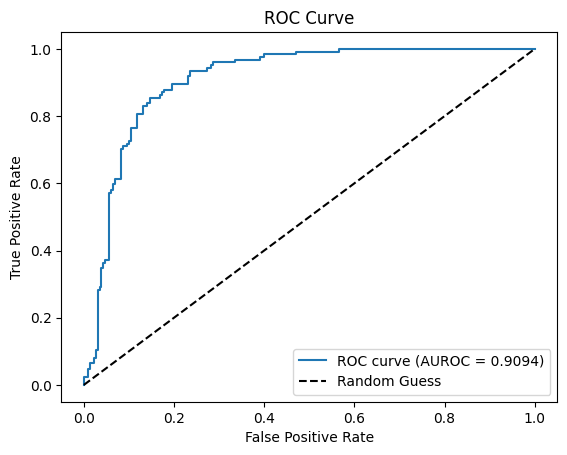

In [35]:
def create_graphs_without_captioning(embeddings):
    graphs = []
    for embed in embeddings:
        
        node_features = torch.stack(
            [embed["image_embedding"], embed["meme_text_embedding"]] + list(embed["vqa_embeddings"])
        ) 

        
        num_nodes = node_features.size(0)
        edge_indices = [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        
        label = torch.tensor(embed["label"], dtype=torch.long)
        graph = Data(x=node_features, edge_index=edge_index, y=label)
        graphs.append(graph)
    return graphs


train_graphs_no_caption = create_graphs_without_captioning(train_embeddings)
val_graphs_no_caption = create_graphs_without_captioning(val_embeddings)
test_graphs_no_caption = create_graphs_without_captioning(test_embeddings)


batch_size = 32
train_loader_no_caption = DataLoader(train_graphs_no_caption, batch_size=batch_size, shuffle=True)
val_loader_no_caption = DataLoader(val_graphs_no_caption, batch_size=batch_size, shuffle=False)
test_loader_no_caption = DataLoader(test_graphs_no_caption, batch_size=batch_size, shuffle=False)


input_dim_no_caption = train_graphs_no_caption[0].x.size(-1)  # 노드 특징 크기
model_no_caption = EnhancedGAT(input_dim_no_caption, hidden_dim, output_dim).to(device)

optimizer = Adam(model_no_caption.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


best_val_loss_no_caption = float('inf')
early_stop_counter_no_caption = 0

print("Starting training without Captioning...")
for epoch in range(epochs):
    
    model_no_caption.train()
    train_loss_no_caption = 0
    for batch in train_loader_no_caption:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        optimizer.zero_grad()
        out = model_no_caption(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss_no_caption += loss.item()
    train_loss_no_caption /= len(train_loader_no_caption)

    model_no_caption.eval()
    val_loss_no_caption = 0
    val_preds_no_caption, val_labels_no_caption = [], []
    with torch.no_grad():
        for batch in val_loader_no_caption:
            batch = batch.to(device)
            if batch.x.dim() == 3:
                batch.x = batch.x.squeeze(1)
            out = model_no_caption(batch)
            loss = criterion(out, batch.y)
            val_loss_no_caption += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds_no_caption.extend(preds)
            val_labels_no_caption.extend(labels)
    val_loss_no_caption /= len(val_loader_no_caption)
    val_accuracy_no_caption = accuracy_score(val_labels_no_caption, val_preds_no_caption)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_no_caption:.4f}, Validation Loss: {val_loss_no_caption:.4f}, Validation Accuracy: {val_accuracy_no_caption:.4f}")

    # Early stopping logic
    if val_loss_no_caption < best_val_loss_no_caption:
        best_val_loss_no_caption = val_loss_no_caption
        early_stop_counter_no_caption = 0
        torch.save(model_no_caption.state_dict(), "best_model_no_caption.pt")
    else:
        early_stop_counter_no_caption += 1
        if early_stop_counter_no_caption >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    scheduler.step()

print("Training without Captioning complete.")

print("Starting testing without Captioning...")
model_no_caption.load_state_dict(torch.load("best_model_no_caption.pt"))
model_no_caption.eval()
test_preds_no_caption, test_labels_no_caption, test_proba_no_caption = [], [], []
with torch.no_grad():
    for batch in test_loader_no_caption:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        out = model_no_caption(batch)
        preds = out.argmax(dim=1).cpu().numpy() 
        proba = torch.exp(out).cpu().numpy()  
        labels = batch.y.cpu().numpy()

        test_preds_no_caption.extend(preds)
        test_labels_no_caption.extend(labels)
        test_proba_no_caption.extend(proba)

test_proba_no_caption = np.array(test_proba_no_caption)
test_accuracy_no_caption = accuracy_score(test_labels_no_caption, test_preds_no_caption)
test_auroc_no_caption = roc_auc_score(test_labels_no_caption, test_proba_no_caption[:, 1])

conf_matrix_no_caption = confusion_matrix(test_labels_no_caption, test_preds_no_caption)
print(f"Test Accuracy without Captioning: {test_accuracy_no_caption:.4f}")
print(f"Test AUROC without Captioning: {test_auroc_no_caption:.4f}")
print("Confusion Matrix without Captioning:")
print(conf_matrix_no_caption)

plot_roc_curve(test_labels_no_caption, test_proba_no_caption[:, 1])

Without Image

Starting training without Image...
Epoch 1/50, Train Loss: 0.5463, Validation Loss: 0.5173, Validation Accuracy: 0.7288
Epoch 2/50, Train Loss: 0.4330, Validation Loss: 0.5225, Validation Accuracy: 0.7288
Epoch 3/50, Train Loss: 0.3938, Validation Loss: 0.5417, Validation Accuracy: 0.7288
Epoch 4/50, Train Loss: 0.3589, Validation Loss: 0.6317, Validation Accuracy: 0.7458
Epoch 5/50, Train Loss: 0.3262, Validation Loss: 0.6282, Validation Accuracy: 0.7062
Epoch 6/50, Train Loss: 0.3081, Validation Loss: 0.7087, Validation Accuracy: 0.7006
Early stopping at epoch 6
Training without Image complete.
Starting testing without Image...
Test Accuracy without Image: 0.8023
Test AUROC without Image: 0.8596
Confusion Matrix without Image:
[[197  33]
 [ 37  87]]


/tmp/ipykernel_30/2089451824.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_image.load_state_dict(torch.load("best_model_no_image.pt"))


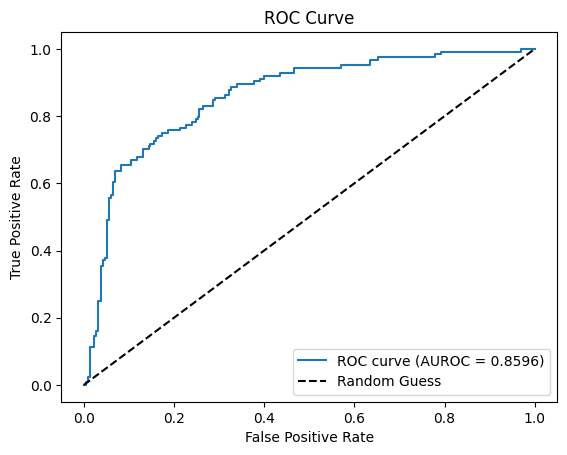

In [37]:
def create_graphs_without_image(embeddings):
    graphs = []
    for embed in embeddings:
        node_features = torch.stack(
            [embed["caption_embedding"], embed["meme_text_embedding"]] + list(embed["vqa_embeddings"])
        ) 

        num_nodes = node_features.size(0)
        edge_indices = [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        label = torch.tensor(embed["label"], dtype=torch.long)
        graph = Data(x=node_features, edge_index=edge_index, y=label)
        graphs.append(graph)
    return graphs

train_graphs_no_image = create_graphs_without_image(train_embeddings)
val_graphs_no_image = create_graphs_without_image(val_embeddings)
test_graphs_no_image = create_graphs_without_image(test_embeddings)

batch_size = 32
train_loader_no_image = DataLoader(train_graphs_no_image, batch_size=batch_size, shuffle=True)
val_loader_no_image = DataLoader(val_graphs_no_image, batch_size=batch_size, shuffle=False)
test_loader_no_image = DataLoader(test_graphs_no_image, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim_no_image = train_graphs_no_image[0].x.size(-1)
hidden_dim = 128
output_dim = 2  # Binary classification
model_no_image = EnhancedGAT(input_dim_no_image, hidden_dim, output_dim).to(device)

optimizer = Adam(model_no_image.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Early stopping setup
best_val_loss_no_image = float('inf')
early_stop_counter_no_image = 0
patience = 5

# Training and validation loop
epochs = 50
print("Starting training without Image...")
for epoch in range(epochs):
    # Training phase
    model_no_image.train()
    train_loss_no_image = 0
    for batch in train_loader_no_image:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        optimizer.zero_grad()
        out = model_no_image(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss_no_image += loss.item()
    train_loss_no_image /= len(train_loader_no_image)

    # Validation phase
    model_no_image.eval()
    val_loss_no_image = 0
    val_preds_no_image, val_labels_no_image = [], []
    with torch.no_grad():
        for batch in val_loader_no_image:
            batch = batch.to(device)
            if batch.x.dim() == 3:
                batch.x = batch.x.squeeze(1)
            out = model_no_image(batch)
            loss = criterion(out, batch.y)
            val_loss_no_image += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds_no_image.extend(preds)
            val_labels_no_image.extend(labels)
    val_loss_no_image /= len(val_loader_no_image)
    val_accuracy_no_image = accuracy_score(val_labels_no_image, val_preds_no_image)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_no_image:.4f}, Validation Loss: {val_loss_no_image:.4f}, Validation Accuracy: {val_accuracy_no_image:.4f}")

    
    if val_loss_no_image < best_val_loss_no_image:
        best_val_loss_no_image = val_loss_no_image
        early_stop_counter_no_image = 0
        torch.save(model_no_image.state_dict(), "best_model_no_image.pt")
    else:
        early_stop_counter_no_image += 1
        if early_stop_counter_no_image >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    scheduler.step()

print("Training without Image complete.")


print("Starting testing without Image...")
model_no_image.load_state_dict(torch.load("best_model_no_image.pt"))
model_no_image.eval()
test_preds_no_image, test_labels_no_image, test_proba_no_image = [], [], []
with torch.no_grad():
    for batch in test_loader_no_image:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        out = model_no_image(batch)
        preds = out.argmax(dim=1).cpu().numpy()
        proba = torch.exp(out).cpu().numpy() 
        labels = batch.y.cpu().numpy()

        test_preds_no_image.extend(preds)
        test_labels_no_image.extend(labels)
        test_proba_no_image.extend(proba)

test_proba_no_image = np.array(test_proba_no_image)
test_accuracy_no_image = accuracy_score(test_labels_no_image, test_preds_no_image)
test_auroc_no_image = roc_auc_score(test_labels_no_image, test_proba_no_image[:, 1])

conf_matrix_no_image = confusion_matrix(test_labels_no_image, test_preds_no_image)
print(f"Test Accuracy without Image: {test_accuracy_no_image:.4f}")
print(f"Test AUROC without Image: {test_auroc_no_image:.4f}")
print("Confusion Matrix without Image:")
print(conf_matrix_no_image)
plot_roc_curve(test_labels_no_image, test_proba_no_image[:, 1])

Without Meme TEXT

Starting training without Text...
Epoch 1/50, Train Loss: 0.5167, Validation Loss: 0.5191, Validation Accuracy: 0.7627
Epoch 2/50, Train Loss: 0.4343, Validation Loss: 0.4745, Validation Accuracy: 0.7966
Epoch 3/50, Train Loss: 0.4027, Validation Loss: 0.4852, Validation Accuracy: 0.7627
Epoch 4/50, Train Loss: 0.3894, Validation Loss: 0.4965, Validation Accuracy: 0.7853
Epoch 5/50, Train Loss: 0.3549, Validation Loss: 0.5583, Validation Accuracy: 0.7797
Epoch 6/50, Train Loss: 0.3320, Validation Loss: 0.6143, Validation Accuracy: 0.7345
Epoch 7/50, Train Loss: 0.3142, Validation Loss: 0.6562, Validation Accuracy: 0.7627
Early stopping at epoch 7
Training without Text complete.
Starting testing without Text...
Test Accuracy without Text: 0.8107
Test AUROC without Text: 0.8793
Confusion Matrix without Text:
[[207  23]
 [ 44  80]]


/tmp/ipykernel_30/2900771551.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_text.load_state_dict(torch.load("best_model_no_text.pt"))


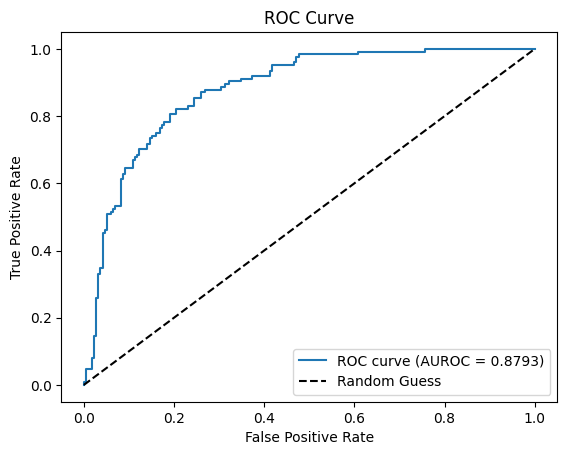

In [38]:
def create_graphs_without_text(embeddings):
    graphs = []
    for embed in embeddings:
        node_features = torch.stack(
            [embed["image_embedding"], embed["caption_embedding"]] + list(embed["vqa_embeddings"])
        ) 

        num_nodes = node_features.size(0)
        edge_indices = [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        label = torch.tensor(embed["label"], dtype=torch.long)
        graph = Data(x=node_features, edge_index=edge_index, y=label)
        graphs.append(graph)
    return graphs

train_graphs_no_text = create_graphs_without_text(train_embeddings)
val_graphs_no_text = create_graphs_without_text(val_embeddings)
test_graphs_no_text = create_graphs_without_text(test_embeddings)

batch_size = 32
train_loader_no_text = DataLoader(train_graphs_no_text, batch_size=batch_size, shuffle=True)
val_loader_no_text = DataLoader(val_graphs_no_text, batch_size=batch_size, shuffle=False)
test_loader_no_text = DataLoader(test_graphs_no_text, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim_no_text = train_graphs_no_text[0].x.size(-1)
hidden_dim = 128
output_dim = 2  
model_no_text = EnhancedGAT(input_dim_no_text, hidden_dim, output_dim).to(device)

optimizer = Adam(model_no_text.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_loss_no_text = float('inf')
early_stop_counter_no_text = 0
patience = 5

epochs = 50
print("Starting training without Text...")
for epoch in range(epochs):
 
    model_no_text.train()
    train_loss_no_text = 0
    for batch in train_loader_no_text:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        optimizer.zero_grad()
        out = model_no_text(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss_no_text += loss.item()
    train_loss_no_text /= len(train_loader_no_text)


    model_no_text.eval()
    val_loss_no_text = 0
    val_preds_no_text, val_labels_no_text = [], []
    with torch.no_grad():
        for batch in val_loader_no_text:
            batch = batch.to(device)
            if batch.x.dim() == 3:
                batch.x = batch.x.squeeze(1)
            out = model_no_text(batch)
            loss = criterion(out, batch.y)
            val_loss_no_text += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds_no_text.extend(preds)
            val_labels_no_text.extend(labels)
    val_loss_no_text /= len(val_loader_no_text)
    val_accuracy_no_text = accuracy_score(val_labels_no_text, val_preds_no_text)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_no_text:.4f}, Validation Loss: {val_loss_no_text:.4f}, Validation Accuracy: {val_accuracy_no_text:.4f}")


    if val_loss_no_text < best_val_loss_no_text:
        best_val_loss_no_text = val_loss_no_text
        early_stop_counter_no_text = 0
        torch.save(model_no_text.state_dict(), "best_model_no_text.pt")
    else:
        early_stop_counter_no_text += 1
        if early_stop_counter_no_text >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    scheduler.step()

print("Training without Text complete.")

# Test phase
print("Starting testing without Text...")
model_no_text.load_state_dict(torch.load("best_model_no_text.pt"))
model_no_text.eval()
test_preds_no_text, test_labels_no_text, test_proba_no_text = [], [], []
with torch.no_grad():
    for batch in test_loader_no_text:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        out = model_no_text(batch)
        preds = out.argmax(dim=1).cpu().numpy()
        proba = torch.exp(out).cpu().numpy()  
        labels = batch.y.cpu().numpy()

        test_preds_no_text.extend(preds)
        test_labels_no_text.extend(labels)
        test_proba_no_text.extend(proba)

test_proba_no_text = np.array(test_proba_no_text)


test_accuracy_no_text = accuracy_score(test_labels_no_text, test_preds_no_text)
test_auroc_no_text = roc_auc_score(test_labels_no_text, test_proba_no_text[:, 1])


conf_matrix_no_text = confusion_matrix(test_labels_no_text, test_preds_no_text)
print(f"Test Accuracy without Text: {test_accuracy_no_text:.4f}")
print(f"Test AUROC without Text: {test_auroc_no_text:.4f}")
print("Confusion Matrix without Text:")
print(conf_matrix_no_text)


plot_roc_curve(test_labels_no_text, test_proba_no_text[:, 1])

Without captioning and VQA(ONLY MEME TEXT, IMAGE)

In [39]:
def create_graphs_without_caption_vqa(embeddings):
    graphs = []
    for embed in embeddings:
        node_features = torch.stack(
            [embed["image_embedding"], embed["meme_text_embedding"]]
        )  # [num_nodes, feature_dim]

        num_nodes = node_features.size(0)
        edge_indices = [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        label = torch.tensor(embed["label"], dtype=torch.long)
        graph = Data(x=node_features, edge_index=edge_index, y=label)
        graphs.append(graph)
    return graphs

train_graphs_no_caption_vqa = create_graphs_without_caption_vqa(train_embeddings)
val_graphs_no_caption_vqa = create_graphs_without_caption_vqa(val_embeddings)
test_graphs_no_caption_vqa = create_graphs_without_caption_vqa(test_embeddings)

batch_size = 32
train_loader_no_caption_vqa = DataLoader(train_graphs_no_caption_vqa, batch_size=batch_size, shuffle=True)
val_loader_no_caption_vqa = DataLoader(val_graphs_no_caption_vqa, batch_size=batch_size, shuffle=False)
test_loader_no_caption_vqa = DataLoader(test_graphs_no_caption_vqa, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim_no_caption_vqa = train_graphs_no_caption_vqa[0].x.size(-1)
hidden_dim = 128
output_dim = 2  # Binary classification
model_no_caption_vqa = EnhancedGAT(input_dim_no_caption_vqa, hidden_dim, output_dim).to(device)

optimizer = Adam(model_no_caption_vqa.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_loss_no_caption_vqa = float('inf')
early_stop_counter_no_caption_vqa = 0
patience = 5

epochs = 50
print("Starting training without Caption & VQA...")
for epoch in range(epochs):
    # Training phase
    model_no_caption_vqa.train()
    train_loss_no_caption_vqa = 0
    for batch in train_loader_no_caption_vqa:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        optimizer.zero_grad()
        out = model_no_caption_vqa(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss_no_caption_vqa += loss.item()
    train_loss_no_caption_vqa /= len(train_loader_no_caption_vqa)

    # Validation phase
    model_no_caption_vqa.eval()
    val_loss_no_caption_vqa = 0
    val_preds_no_caption_vqa, val_labels_no_caption_vqa, val_proba_no_caption_vqa = [], [], []
    with torch.no_grad():
        for batch in val_loader_no_caption_vqa:
            batch = batch.to(device)
            if batch.x.dim() == 3:
                batch.x = batch.x.squeeze(1)
            out = model_no_caption_vqa(batch)
            loss = criterion(out, batch.y)
            val_loss_no_caption_vqa += loss.item()
            preds = out.argmax(dim=1).cpu().numpy()
            proba = torch.exp(out).cpu().numpy()  
            labels = batch.y.cpu().numpy()
            val_preds_no_caption_vqa.extend(preds)
            val_labels_no_caption_vqa.extend(labels)
            val_proba_no_caption_vqa.extend(proba)
    val_loss_no_caption_vqa /= len(val_loader_no_caption_vqa)
    val_accuracy_no_caption_vqa = accuracy_score(val_labels_no_caption_vqa, val_preds_no_caption_vqa)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_no_caption_vqa:.4f}, Validation Loss: {val_loss_no_caption_vqa:.4f}, Validation Accuracy: {val_accuracy_no_caption_vqa:.4f}")

    if val_loss_no_caption_vqa < best_val_loss_no_caption_vqa:
        best_val_loss_no_caption_vqa = val_loss_no_caption_vqa
        early_stop_counter_no_caption_vqa = 0
        torch.save(model_no_caption_vqa.state_dict(), "best_model_no_caption_vqa.pt")
    else:
        early_stop_counter_no_caption_vqa += 1
        if early_stop_counter_no_caption_vqa >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    scheduler.step()

print("Training without Caption & VQA complete.")
print("Starting testing without Caption & VQA...")
model_no_caption_vqa.load_state_dict(torch.load("best_model_no_caption_vqa.pt"))
model_no_caption_vqa.eval()
test_preds_no_caption_vqa, test_labels_no_caption_vqa, test_proba_no_caption_vqa = [], [], []
with torch.no_grad():
    for batch in test_loader_no_caption_vqa:
        batch = batch.to(device)
        if batch.x.dim() == 3:
            batch.x = batch.x.squeeze(1)
        out = model_no_caption_vqa(batch)
        preds = out.argmax(dim=1).cpu().numpy()
        proba = torch.exp(out).cpu().numpy()  
        labels = batch.y.cpu().numpy()
        test_preds_no_caption_vqa.extend(preds)
        test_labels_no_caption_vqa.extend(labels)
        test_proba_no_caption_vqa.extend(proba)

test_proba_no_caption_vqa = np.array(test_proba_no_caption_vqa)
test_accuracy_no_caption_vqa = accuracy_score(test_labels_no_caption_vqa, test_preds_no_caption_vqa)

test_auroc_no_caption_vqa = roc_auc_score(test_labels_no_caption_vqa, test_proba_no_caption_vqa[:, 1])

conf_matrix_no_caption_vqa = confusion_matrix(test_labels_no_caption_vqa, test_preds_no_caption_vqa)
print(f"Test Accuracy without Caption & VQA: {test_accuracy_no_caption_vqa:.4f}")
print(f"Test AUROC without Caption & VQA: {test_auroc_no_caption_vqa:.4f}")
print("Confusion Matrix without Caption & VQA:")
print(conf_matrix_no_caption_vqa)

Starting training without Caption & VQA...
Epoch 1/50, Train Loss: 0.4752, Validation Loss: 0.5299, Validation Accuracy: 0.7345
Epoch 2/50, Train Loss: 0.4101, Validation Loss: 0.6647, Validation Accuracy: 0.7345
Epoch 3/50, Train Loss: 0.3753, Validation Loss: 0.5346, Validation Accuracy: 0.7288
Epoch 4/50, Train Loss: 0.3389, Validation Loss: 0.5722, Validation Accuracy: 0.7345
Epoch 5/50, Train Loss: 0.3198, Validation Loss: 0.4980, Validation Accuracy: 0.7910
Epoch 6/50, Train Loss: 0.3010, Validation Loss: 0.8573, Validation Accuracy: 0.7175
Epoch 7/50, Train Loss: 0.2565, Validation Loss: 0.6486, Validation Accuracy: 0.7288
Epoch 8/50, Train Loss: 0.2244, Validation Loss: 0.9477, Validation Accuracy: 0.7062
Epoch 9/50, Train Loss: 0.2252, Validation Loss: 0.8850, Validation Accuracy: 0.7458
Epoch 10/50, Train Loss: 0.2009, Validation Loss: 0.9800, Validation Accuracy: 0.7232
Early stopping at epoch 10
Training without Caption & VQA complete.
Starting testing without Caption & VQA

/tmp/ipykernel_30/3217377981.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_caption_vqa.load_state_dict(torch.load("best_model_no_caption_vqa.pt"))


**Image only CNN**

In [3]:
data_csv_path = '/kaggle/input/with-vqa-data/output_vqa_answers (2).csv'
image_folder_path = '/kaggle/input/requirement/resources/resources/datasets/harmeme/img'
data = pd.read_csv(data_csv_path)

class HarmemeDataset(Dataset):
    def __init__(self, data, image_folder, transform=None):
        self.data = data
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image'])
        label = row['label']

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = data[data['split'] == 'train']
val_data = data[data['split'] == 'val']
test_data = data[data['split'] == 'test']

train_dataset = HarmemeDataset(train_data, image_folder_path, transform=transform)
val_dataset = HarmemeDataset(val_data, image_folder_path, transform=transform)
test_dataset = HarmemeDataset(test_data, image_folder_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        validate_model(model, val_loader, criterion)

def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    val_auroc = roc_auc_score(all_labels, all_probs)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUROC: {val_auroc:.4f}')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    test_auroc = roc_auc_score(all_labels, all_probs)
    print(f'Test Accuracy: {test_accuracy:.4f}, AUROC: {test_auroc:.4f}')

test_model(model, test_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


Epoch 1/10, Loss: 0.6866
Validation Loss: 0.6908, Accuracy: 0.5819, AUROC: 0.5448
Epoch 2/10, Loss: 0.6343
Validation Loss: 0.6091, Accuracy: 0.6667, AUROC: 0.6802
Epoch 3/10, Loss: 0.6485
Validation Loss: 1.1399, Accuracy: 0.6723, AUROC: 0.5150
Epoch 4/10, Loss: 0.6540
Validation Loss: 0.6536, Accuracy: 0.6384, AUROC: 0.5170
Epoch 5/10, Loss: 0.6427
Validation Loss: 0.7192, Accuracy: 0.5932, AUROC: 0.5147
Epoch 6/10, Loss: 0.6365
Validation Loss: 0.6451, Accuracy: 0.6554, AUROC: 0.5561
Epoch 7/10, Loss: 0.6238
Validation Loss: 0.6277, Accuracy: 0.6723, AUROC: 0.6139
Epoch 8/10, Loss: 0.6204
Validation Loss: 0.6737, Accuracy: 0.6328, AUROC: 0.5194
Epoch 9/10, Loss: 0.6214
Validation Loss: 0.6307, Accuracy: 0.6610, AUROC: 0.6419
Epoch 10/10, Loss: 0.6119
Validation Loss: 0.6470, Accuracy: 0.6610, AUROC: 0.5961
Test Accuracy: 0.6158, AUROC: 0.5983


**text-only**

In [4]:
data_csv_path = '/kaggle/input/with-vqa-data/output_vqa_answers (2).csv'

# Load the CSV file
data = pd.read_csv(data_csv_path)

# Extract text and labels
texts = data['text'].tolist()
labels = data['label'].tolist()

# Split the data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    return encodings, labels

train_encodings, train_labels = tokenize_data(train_texts, train_labels)
val_encodings, val_labels = tokenize_data(val_texts, val_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)
test_dataset = TextDataset(test_encodings, test_labels)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = pred.predictions[:, 1]
    acc = accuracy_score(labels, preds)
    auroc = roc_auc_score(labels, probs)
    return {'accuracy': acc, 'auroc': auroc}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Test the model
def evaluate_on_test(trainer, test_dataset):
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)
    probs = predictions.predictions[:, 1]
    print("Test Accuracy:", accuracy_score(test_labels, preds))
    print("Test AUROC:", roc_auc_score(test_labels, probs))
    print("Classification Report:\n", classification_report(test_labels, preds))

evaluate_on_test(trainer, test_dataset)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimen

Epoch,Training Loss,Validation Loss,Accuracy,Auroc
1,0.614900,0.587978,0.714689,0.758801
2,0.488900,0.507326,0.751412,0.800736
3,0.453300,0.536453,0.765537,0.823422
4,0.282000,0.606350,0.748588,0.814586
5,0.267300,0.633801,0.742938,0.790708


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.7746478873239436
Test AUROC: 0.8292087542087542
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       220
           1       0.74      0.62      0.68       135

    accuracy                           0.77       355
   macro avg       0.77      0.75      0.75       355
weighted avg       0.77      0.77      0.77       355



**text+vqa+caption**

In [7]:
text_columns = [
    'text',
    'caption',
    'What is the race of the person in the image?',
    'What is the gender of the person in the image?',
    'What is the religion of the person in the image?',
    'Which country does the person in the image come from?',
    'Are there disabled people in the image?',
    'What animal is in the image?',
    'Is there a person in the image?',
    'Is there an animal in the image?'
]

data['combined_text'] = data[text_columns].fillna('N/A').apply(lambda row: ' '.join(f"{col}: {row[col]}" for col in text_columns), axis=1)

train_data = data[data['split'] == 'train']
val_data = data[data['split'] == 'val']
test_data = data[data['split'] == 'test']

train_texts = train_data['combined_text'].tolist()
train_labels = train_data['label'].tolist()
val_texts = val_data['combined_text'].tolist()
val_labels = val_data['label'].tolist()
test_texts = test_data['combined_text'].tolist()
test_labels = test_data['label'].tolist()

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    return encodings, labels

train_encodings, train_labels = tokenize_data(train_texts, train_labels)
val_encodings, val_labels = tokenize_data(val_texts, val_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)
test_dataset = TextDataset(test_encodings, test_labels)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()
evaluate_on_test(trainer, test_dataset)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimen

Epoch,Training Loss,Validation Loss,Accuracy,Auroc
1,0.566600,0.554394,0.700565,0.772329
2,0.436500,0.551882,0.689266,0.810062
3,0.443900,0.567062,0.666667,0.827586
4,0.274200,0.708729,0.661017,0.789288
5,0.309200,0.769102,0.700565,0.785472
6,0.213700,0.974578,0.655367,0.763708
7,0.106600,1.049029,0.694915,0.808084
8,0.109600,1.239352,0.661017,0.813878
9,0.035800,1.417729,0.700565,0.802148
10,0.026800,1.544878,0.683616,0.800735


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.7966101694915254
Test AUROC: 0.8042776998597476
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       230
           1       0.72      0.68      0.70       124

    accuracy                           0.80       354
   macro avg       0.78      0.77      0.77       354
weighted avg       0.79      0.80      0.79       354



text+  vqa


In [8]:
data = pd.read_csv(data_csv_path)

text_columns = [
    'text',
    'What is the race of the person in the image?',
    'What is the gender of the person in the image?',
    'What is the religion of the person in the image?',
    'Which country does the person in the image come from?',
    'Are there disabled people in the image?',
    'What animal is in the image?',
    'Is there a person in the image?',
    'Is there an animal in the image?'
]

data['combined_text'] = data[text_columns].fillna('N/A').apply(lambda row: ' '.join(f"{col}: {row[col]}" for col in text_columns), axis=1)

train_data = data[data['split'] == 'train']
val_data = data[data['split'] == 'val']
test_data = data[data['split'] == 'test']

train_texts = train_data['combined_text'].tolist()
train_labels = train_data['label'].tolist()
val_texts = val_data['combined_text'].tolist()
val_labels = val_data['label'].tolist()
test_texts = test_data['combined_text'].tolist()
test_labels = test_data['label'].tolist()

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)
test_dataset = TextDataset(test_encodings, test_labels)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

evaluate_on_test(trainer, test_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimen

Epoch,Training Loss,Validation Loss,Accuracy,Auroc
1,0.565400,0.547318,0.689266,0.776003
2,0.433500,0.568866,0.677966,0.783635
3,0.449400,0.642058,0.666667,0.789853
4,0.323200,0.846240,0.581921,0.776710
5,0.289900,0.842976,0.649718,0.760175
6,0.247700,1.071620,0.649718,0.676230
7,0.101300,1.261353,0.655367,0.778547
8,0.069700,1.379377,0.666667,0.749576


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.807909604519774
Test AUROC: 0.821914446002805
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       230
           1       0.75      0.69      0.71       124

    accuracy                           0.81       354
   macro avg       0.79      0.78      0.78       354
weighted avg       0.81      0.81      0.81       354



text+caption


In [2]:
data = pd.read_csv(data_csv_path)

text_columns = [
    'text',
    'caption',
    'Are there disabled people in the image?',
    'What animal is in the image?',
    'Is there a person in the image?',
    'Is there an animal in the image?'
]

data['combined_text'] = data[text_columns].fillna('N/A').apply(lambda row: ' '.join(f"{col}: {row[col]}" for col in text_columns), axis=1)

train_data = data[data['split'] == 'train']
val_data = data[data['split'] == 'val']
test_data = data[data['split'] == 'test']

train_texts = train_data['combined_text'].tolist()
train_labels = train_data['label'].tolist()
val_texts = val_data['combined_text'].tolist()
val_labels = val_data['label'].tolist()
test_texts = test_data['combined_text'].tolist()
test_labels = test_data['label'].tolist()

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings, train_labels = tokenize_data(train_texts, train_labels)
val_encodings, val_labels = tokenize_data(val_texts, val_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)
test_dataset = TextDataset(test_encodings, test_labels)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()
evaluate_on_test(trainer, test_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimen

Epoch,Training Loss,Validation Loss,Accuracy,Auroc
1,0.581500,0.552959,0.723164,0.792679
2,0.436500,0.557990,0.655367,0.789288
3,0.444100,0.578466,0.689266,0.810062
4,0.308600,0.624227,0.683616,0.833239
5,0.292300,0.787804,0.711864,0.792256


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.807909604519774
Test AUROC: 0.8240182328190743
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       230
           1       0.77      0.65      0.70       124

    accuracy                           0.81       354
   macro avg       0.80      0.77      0.78       354
weighted avg       0.80      0.81      0.80       354

